# Dependencies

This is a Python 3 package that relies on the following packages: NumPy, SciPy, Numba, Numexpr. It can be combined with packages like Dask to parallelize propagation jobs. 

# Overview

Lightbeam is a bare-bones beam propagator. This means that the code can be very flexible, but also that you may have to code certain functionalities yourself. The purpose of this notebook is to reveal the different components of the code so you can make use of them. 

There are three main classes of objects that Lightbeam uses.
1. <strong>Mesh</strong> objects, which control the physical size of the simulation zone as well as how that zone is subdivided.
2. <strong>Optics</strong> objects, which encapsulate the geometry and material properties of the waveguide you are simulating.
3. <strong>Propagator</strong> objects, which control parameters regarding the beam propagation algorithm.

We will go over each component in turn. Regarding units, note that the specific choice does not matter. The code only requires that every parameter with a length attached to it is reported in the same units.

## Meshes

### Initialization

To initialize a mesh, we use the RectMesh3D class. The required args are:

<strong>xw</strong>: total width of the simulation zone in the x direction.<br>
<strong>yw</strong>: total width in the y direction.<br>
<strong>zw</strong>: total length in the z direction.<br>
<strong>ds</strong>: coarsest grid spacing in the transverse (x,y) plane. Note that this grid can later be subdivided for greater accuracy.<br>
<strong>dz</strong>: grid spacing along the z direction.<br>

Optional args: 

<strong>PML</strong>: the number of extra grid points to be padded around the simulation zone (specifically in the xy direction). Material in this outer zone will be tuned to damp any outgoing waves, reducing reflection across the simulation boundary. The specific technique used is called "perfectly matched layers" (PML). The default value of 4 is a good place to start but if you see internal reflections, try upping the count.

<strong>xwfunc,ywfunc</strong>: these are functions which take in a z value and return a value for xw,yw. This allows the simulation zone to change in size, which is theoretically useful in simulating tapered waveguides. However, this option is not well tested yet. Leaving these parameters as None to leave xw,yw fixed.

### Behind the scenes

For the curious ... the RectMesh3D class is primarily a wrapper for the RectMesh2D class, which handles all the adaptive meshing and contains the important class methods. Specifically, the RectMesh3D class stores a RectMesh2D object under the class variable <strong>self.xy</strong>. The type of adaptive mesh implemented here is the simplest, where x and y are subdivided independently. This is a less computationally efficient approach, but maintains 4<sup>th</sup> order accuracy [1]. Resetting the transverse grid to coarse, uniform spacing is handled by <strong>RectMesh2D.reinit()</strong> while grid refinement is handled by <strong>RectMesh2D.refine_base()</strong>. The local degree of refinement required is currently measured from the product of field amplitude and magnitude of the field's second derivative; I have empirically found this method to work well enough.

(5001, 81, 81)
(81, 81)


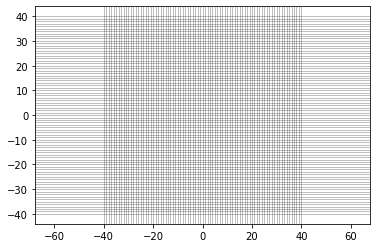

In [22]:
### Example Initialization ###

# make a 64x64x10000 um mesh, wrapped with 8 PML cells. 
# set the transverse spacing to 1 um and the longitudinal spacing to 2 um.

from mesh import RectMesh3D

xw = 64 #um
yw= 64 #um
zw = 10000 #um
num_PML = 8 #grid units

ds = 1 #um
dz = 2 #um

mesh = RectMesh3D(xw,yw,zw,ds,dz,num_PML)

### some properties and class functions ###

# shape
print(mesh.shape)

# shape of transverse grid only
print(mesh.xy.shape)

# plot the grid lines of the transverse mesh
mesh.xy.plot_mesh()


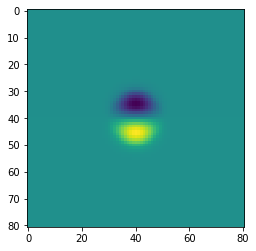

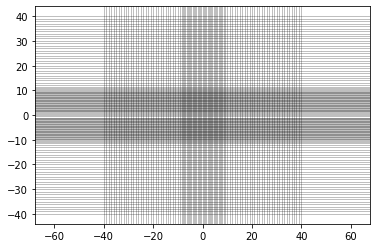

In [23]:
### Mesh refinement example ###

# suppose our field is the LP11 mode, core radius 10 um
# we want to subdivide our field according to this field.

import matplotlib.pyplot as plt
import LPmodes
import numpy as np
from misc import normalize

# initial setup to generate the LP11 field
x_grid , y_grid = mesh.xg , mesh.yg
rcore = 10 #um
wavelength = 1 #um
ncore = 1.5
nclad = 1.495
field = normalize(LPmodes.lpfield(x_grid,y_grid,1,1,rcore,wavelength,ncore,nclad))
plt.imshow(np.real(field))
plt.show()

ucrit = 6e-5 # lower this parameter to increase subdivisions. note that by default the code only allows for 6 subdivisions,
             # so that the minimum grid size will be ds/2^6. This can be altered under the parameter RectMesh2D.max_iters.

mesh.xy.refine_base(field,ucrit)
mesh.xy.plot_mesh()

## Optics

Since there is no GUI, implementing waveguide geometries will be more cumbersome than something like a CAD environment. Lightbeam provides a skeleton structure for users to define their own waveguide geometries, as well as some pre-defined classes for certain types of photonic lanterns.

### Class types

#### OpticPrim

The base class of all optics is OpticPrim, which contains the basic framework for describing any homogeneous (i.e. only one refractive index) optical structure. Any custom-defined class for homogeneous optical structures should inherit from this class, and requires the definition of two functions: 

1. <strong>self._bbox(z)</strong>: a function that computes the 2D bounding box (xmin,xmax,ymin,ymax) of the optical structure at some given z coordinate.
2. <strong>self._contains(x,y,z)</strong>: a boolean function that determines whether the point (x,y,z) is in the optical structure. This function <strong> must be vectorized</strong>.

Of course the <strong>\__init__()</strong> function will also have to be defined. 

An example OpticPrim class, called __scaled_cyl__, has already been defined. This class can be used to describe any "cylinder" whose cross-sectional diameter and central offset change along the z direction (cylinder caps are assumed to be normal to z).  

#### OpticSys

The next level of complexity is the OpticSys class, which inherits from the OpticPrim class but is really a collection of optical primitives. This class is used to model non-homogeneous optical structures (i.e. anything of interest). Initialization is simple. The required initialization arguments are

1. __elmnts__: a list of OpticPrim objects composing your system. In terms of refractive index, objects later in the list "overwrite" earlier objects.
2. __nb__: the background refractive index in which the optical system is immersed in. Note that this should be similar to to refractive index of the objects in elmnts, to maintain the weakly-guiding approximation which all beam propagation algorithims are based on. For step-index fiber simulation, __nb__ is set to the cladding index (so the cladding is essentially infinite). For photonic lantern simulations, __nb__ is set to the jacket index.

While OpticSys is in principle able to model any waveguide structure, given appropriately defined primitives, for convenience you may wish to define custom classes derived from OpticSys for specific types of waveguides. This has already been done for several photonic lantern geometries, which you can see in __optics.py__.

### Initialization

# References 

[1] Jun Shibayama, Kenji Matsubara, Minoru Sekiguchi, Junji Yamauchi, and Hisamatsu Nakano, "Efficient Nonuniform Schemes for Paraxial and Wide-Angle Finite-Difference Beam Propagation Methods," J. Lightwave Technol. 17, 677- (1999)